# Moon et al
Correctness Ranking Loss (CRL) used for improving the performance of neural network models, particularly in their ability to predict failures (or misclassifications).
Purpose and Outcome: The main goal of CRL is to help the model not only be accurate in its predictions but also to understand and quantify its certainty in those predictions. This can be particularly useful in scenarios where understanding the model's confidence in its predictions is crucial, such as in medical diagnostics or autonomous driving.

In [1]:
pip install torch torchvision

In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.4 MB/s eta 0:00:00


In [3]:
!pip install matplotlib

In [4]:

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/pytorch'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Bayesian.ipynb', 'CRL_moon.ipynb', 'CRL_moon_cifar.ipynb', 'Cifar_baseline.ipynb', 'Cifar_baseline_ResNet.ipynb', 'DAC+Dropout_incomplete.ipynb', 'DAC+Temp.ipynb', 'DAC+Temp_Cifar.ipynb', 'DAC+Temp_Cifar_dropout_swin.ipynb', 'DAC+Temp_Cifar_mixup_labelsmoothing_swin.ipynb', 'DAC+Temp_Cifar_swin.ipynb', 'Dropout.ipynb', 'Dropout_cifar.ipynb', 'FocalLoss.ipynb', 'FocalLoss_cifar.ipynb', 'LabelSmoothing.ipynb', 'LabelSmoothing_cifar.ipynb', 'Mixup.ipynb', 'Mixup_cifar.ipynb', 'ResNet.ipynb', '__init__.py', '__pycache__', 'baseline.ipynb', 'data', 'model', 'py_code', 'result_auroc_OD.json', 'result_auroc_OD_CRL.json', 'result_auroc_OD_LS.json', 'result_auroc_OD_baseline.json', 'result_auroc_OD_dropout.json', 'result_auroc_OD_mixup.json', 'results_DAC_temp.json', 'results_DAC_temp_cifar.json', 'results_DAC_temp_swin.json', 'results_Dropout.json', 'results_Dropout_swin.json', 'results_ECE.json', 'results_ECE_CRL.json', 'results_ECE_LS.json', 'results_ECE_LS_cifar

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset,Dataset
import torchvision.models as models
import torch
from torchvision.transforms import ToPILImage
import numpy as np
import random
from PIL import Image


model = models.resnet50(pretrained=True) #pretrained on imagenet which have 1000 images
num_features = model.fc.in_features  # Get the input features of the final fully connected layer
model.fc = torch.nn.Linear(num_features, 10)  # Replace it with a new fully connected layer with 10 outputs


# Custom Dataset class to load images on-the-fly
class CIFARC_Dataset(Dataset):
    def __init__(self, data: np.ndarray, labels: list, transform=None):
        assert len(data) == len(labels)
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # CIFAR images are in the format (channels, height, width)
        # We need to convert them to (height, width, channels) for PIL
        img = self.data[idx].transpose((1, 2, 0))  # Convert to HxWxC
        img = Image.fromarray(img.astype('uint8'), 'RGB')  # Convert to PIL Image
        label = self.labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

class CombinedCIFARCDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.lengths = [len(d) for d in datasets]
        self.cumulative_lengths = np.cumsum(self.lengths)

    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(f"Index out of range: {idx}")

        # Determine which dataset the index falls into
        dataset_idx = np.searchsorted(self.cumulative_lengths, idx, side='right')
        if dataset_idx > 0:
            relative_idx = idx - self.cumulative_lengths[dataset_idx - 1]
        else:
            relative_idx = idx

        return self.datasets[dataset_idx][relative_idx]


# Transformations for the images
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Get the labels from the CIFAR-10 test set
test_labels = full_test_dataset.targets

# Load CIFAR-10-C dataset
file_path = './data/CIFAR-10-C/zoom_blur.npy'  # Make sure this path is correct
cifar_c_data_blur = np.load(file_path)
cifar_c_data_blur = cifar_c_data_blur.transpose((0, 3, 1, 2))  # Reorder dimensions to match PyTorch's (batch_size, channels, height, width)

# Create an instance of the CIFARC_Dataset with the first 500 images and corresponding labels
cifar_c_dataset_blur = CIFARC_Dataset(data=cifar_c_data_blur[:500], labels=test_labels[:500], transform=transform)


file_path = './data/CIFAR-10-C/speckle_noise.npy'  # Make sure this path is correct
cifar_c_data_speckle = np.load(file_path)
cifar_c_data_speckle = cifar_c_data_speckle.transpose((0, 3, 1, 2))  # Reorder dimensions to match PyTorch's (batch_size, channels, height, width)

# Create an instance of the CIFARC_Dataset with the first 500 images and corresponding labels
cifar_c_dataset_speckle = CIFARC_Dataset(data=cifar_c_data_speckle[:500], labels=test_labels[:500], transform=transform)
# Instantiate the Combined Dataset with blur and speckle datasets
combined_cifar_c_dataset = CombinedCIFARCDataset([cifar_c_dataset_blur, cifar_c_dataset_speckle])
# Define DataLoaders for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_subset, test_subset = random_split(full_test_dataset, [len(full_test_dataset) // 2, len(full_test_dataset) - len(full_test_dataset) // 2])
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)
# Define a DataLoader for the combined dataset
OD_loader = DataLoader(combined_cifar_c_dataset, batch_size=64, shuffle=False, num_workers=2)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.9MB/s]


Files already downloaded and verified
Files already downloaded and verified


All models are trained using SGD with a momentum
of 0.9, an initial learning rate of 0.1, and a weight decay of 5e-4 for 200 epochs
with the mini-batch size of 128 on CIFAR-10 and CIFAR-100. The learning rate is
reduced by a factor of 10 at 80, 130, and 170 epochs. We randomly sample 10% of
training samples as a validation dataset for each task because it is a requirement
for post-calibration methods like temperature scaling [15]. For each experiment,
the mean and standard deviation over three random runs are reported

For the model used in the paper

In [6]:
pip install tqdm tensorboard

# Ad-hoc:
label smoothing
In standard classification tasks, the target labels are often one-hot encoded, meaning a label is represented as 1 for the correct class and 0 for all other classes.
Label smoothing modifies these target labels by reducing the target value for the correct class slightly below 1 and distributing a small amount of this value across the other classes.**bold text**

In [7]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def crl_loss(output, target, history, lambda_rank):
    conf = torch.softmax(output, dim=1)
    confidence, _ = conf.max(dim=1)

    rank_input1 = confidence
    rank_input2 = torch.roll(confidence, -1)
    idx = torch.arange(confidence.size(0), device=confidence.device)
    idx2 = torch.roll(idx, -1)

    rank_target, rank_margin = history.get_target_margin(idx, idx2)
    rank_target_nonzero = rank_target.clone()
    rank_target_nonzero[rank_target_nonzero == 0] = 1
    rank_input2 = rank_input2 + rank_margin / rank_target_nonzero

    ranking_loss = torch.max(torch.zeros_like(rank_input1), -torch.sign(rank_target) * (rank_input1 - rank_input2) + torch.abs(rank_margin))
    cls_loss = torch.nn.functional.cross_entropy(output, target)
    return cls_loss + lambda_rank * ranking_loss.mean()


#track the correctness of each sample over training epochs and calculate the margin for the CRL loss.
# This buffer will store the proportion of times each sample in the training dataset has been correctly classified.

class HistoryBuffer:
    def __init__(self, dataset_size, device):
        self.correct_count = torch.zeros(dataset_size, device=device)
        self.total_count = torch.zeros(dataset_size, device=device)

    def update(self, outputs, targets, indices):
        with torch.no_grad():
            predictions = outputs.max(1)[1]  # Get the predicted class
            correct = (predictions == targets).float()  # Compare with true labels
            self.correct_count[indices] += correct
            self.total_count[indices] += 1

    def get_correct_rate(self, indices):
        correct_rate = self.correct_count[indices] / self.total_count[indices]
        correct_rate[self.total_count[indices] == 0] = 0  # Avoid division by zero
        return correct_rate

    def get_target_margin(self, idx1, idx2):
        correct_rate1 = self.get_correct_rate(idx1)
        correct_rate2 = self.get_correct_rate(idx2)
        rank_target = torch.sign(correct_rate1 - correct_rate2)
        rank_margin = torch.abs(correct_rate1 - correct_rate2)
        return rank_target, rank_margin

train_losses = []
val_accuracies = []
dataset_size = len(train_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Updated Parameters
num_epochs = 10
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4
lambda_rank = 0.1  # Weight for the ranking loss in the total loss
batch_size = 128
history = HistoryBuffer(dataset_size, device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Generate indices for the current batch
        # Assuming your DataLoader does not shuffle data after each epoch
        start_idx = batch_idx * train_loader.batch_size
        end_idx = start_idx + inputs.size(0)
        indices = torch.arange(start_idx, end_idx, device=device)

        loss = crl_loss(outputs, labels, history, lambda_rank)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        history.update(outputs, labels, indices)  # Update the history buffer with the latest predictions


    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%")

print("Finished Training")


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 1/10] Loss: 0.3989 - Val Accuracy: 92.12%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 2/10] Loss: 0.1848 - Val Accuracy: 90.52%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 3/10] Loss: 0.1228 - Val Accuracy: 92.60%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 4/10] Loss: 0.0988 - Val Accuracy: 92.16%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 5/10] Loss: 0.0804 - Val Accuracy: 92.66%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 6/10] Loss: 0.0730 - Val Accuracy: 92.38%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 7/10] Loss: 0.0694 - Val Accuracy: 92.40%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 8/10] Loss: 0.0630 - Val Accuracy: 93.82%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 9/10] Loss: 0.0624 - Val Accuracy: 93.16%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 10/10] Loss: 0.0546 - Val Accuracy: 92.50%
Finished Training


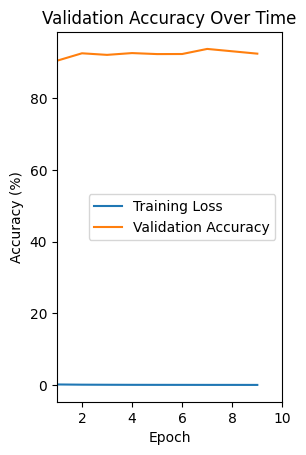

In [8]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

plt.show()


In [10]:
import torch.nn as nn
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model,test_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 92.34%
Average Test Loss: 0.2492


In [11]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model, OD_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 83.20%
Average Test Loss: 0.5403


In [12]:
import torch.nn.functional as F
def compute_ece(probs, labels, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).

    Args:
        probs: Tensor of predicted probabilities of shape [N, C] where C is number of classes.
        labels: Tensor of true labels of shape [N].
        n_bins: Number of bins to use for ECE computation.

    Returns:
        ece: Expected Calibration Error.
    """

    # Get the predicted confidence values (maximum predicted probability)
    confidences, predictions = probs.max(1)

    # Initialize lists to store true positive counts and total count for each bin
    bin_true_positives = [0 for _ in range(n_bins)]
    bin_total = [0 for _ in range(n_bins)]

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_idx in range(n_bins):
        # Indices of items in the current bin
        bin_indices = (confidences > bin_lowers[bin_idx]) & (confidences <= bin_uppers[bin_idx])

        bin_true_positives[bin_idx] += (predictions[bin_indices] == labels[bin_indices]).float().sum().item()
        bin_total[bin_idx] += bin_indices.float().sum().item()

    # Compute bin accuracies and average confidences
    bin_accuracies = [bin_true_positives[i] / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]
    bin_avg_confidences = [torch.sum(confidences[(confidences > bin_lowers[i]) & (confidences <= bin_uppers[i])]).item() / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]

    ece = sum([bin_total[i] / float(probs.size(0)) * abs(bin_avg_confidences[i] - bin_accuracies[i]) for i in range(n_bins)])

    return ece

# After your training/testing loops
# initialization for porbs and truelabels
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece:.4f}")


Expected Calibration Error (ECE): 0.0338


In [13]:
# Sample test result and current datetime
import json
from datetime import datetime
result_ece = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_CRL_cifar.json', 'a') as file:
    file.write(json.dumps(result_ece) + '\n')


The Above code are all for the ID dada,
Below are for the OD data for calculating the ECE for data with concept drift

In [16]:
import torch.nn.functional as F

# After your training/testing loops
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)


model.eval()
with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece_od = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece_od:.4f}")


Expected Calibration Error (ECE): 0.0790


In [17]:
# Sample test result and current datetime
result_ece_od = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece_od  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_OD_CRL_cifar.json', 'a') as file:
    file.write(json.dumps(result_ece_od) + '\n')